In [1]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

from itertools import count
from collections import namedtuple
from torch.autograd import Variable


# parser = argparse.ArgumentParser(description='PyTorch actor-critic example')
# parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
#                     help='discount factor (default: 0.99)')
# parser.add_argument('--seed', type=int, default=543, metavar='N',
#                     help='random seed (default: 1)')
# parser.add_argument('--render', action='store_true',
#                     help='render the environment')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='interval between training status logs (default: 10)')
# args = parser.parse_args()

gamma_rl = 0.99

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from gridworld import GridworldEnv

In [4]:
env = GridworldEnv(shape=(5, 5))

In [5]:
#state_dim = 2 * len(env.state)
state_dim = int(env.nS * 2)
action_dim = int(env.nA)

hidden_layer1_size = 50
hidden_layer2_size = 50

lambda_baseline = 0.1 #best 0.1

entropy_weights = {
    "Alice":0.1,
    "Bob":0.00,
}

eps = 1e-3

In [6]:
def entropy_term(probs):
    return -torch.sum(probs * torch.log(probs))

In [7]:
SavedAction = namedtuple('SavedAction', ['action', 'prob', 'value'])
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(state_dim, hidden_layer1_size)
        nn.init.xavier_normal(self.affine1.weight)
        self.action_head = nn.Linear(hidden_layer2_size, action_dim)
        nn.init.xavier_normal(self.action_head.weight)
        self.value_head = nn.Linear(hidden_layer2_size, 1)
        nn.init.xavier_normal(self.value_head.weight)

        self.saved_actions = []
        self.rewards = []

    def forward(self, s, s_star=None):
        x_onehot = torch.zeros((1, state_dim))
        x_onehot[0][s] = 1
        if(not (s_star is None)):
            x_onehot[0][state_dim // 2 + s_star] = 1
        x_onehot = Variable(x_onehot)
        x = F.relu(self.affine1(x_onehot))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores), state_values

In [8]:
def select_action(state, s_star, model):
    #state = torch.from_numpy(state).int().unsqueeze(0)
    probs, state_value = model(state, s_star)
    action = probs.multinomial()
    model.saved_actions.append(SavedAction(action, probs, state_value))
    return action.data

In [9]:
def update_params(model, optimizer, who="Bob"):
    R = 0
    saved_actions = model.saved_actions
    value_loss = 0
    entropy_loss = 0
    rewards = []
    for r in model.rewards[::-1]:
        R = r + gamma_rl * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    for (action, probs, value), r in zip(saved_actions, rewards):
        reward = r - value.data[0, 0]
        action.reinforce(reward)
        value_loss += lambda_baseline * F.mse_loss(value, Variable(torch.Tensor([r])))
        entropy_loss += -entropy_weights[who] * entropy_term(probs)

    optimizer.zero_grad()
    final_nodes = [value_loss] + [entropy_loss] + list(map(lambda p: p.action, saved_actions))
    gradients = [torch.ones(1)] + [torch.ones(1)] + [None] * len(saved_actions)
    
    autograd.backward(final_nodes, gradients)
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]


In [10]:
def check_equivalence(s1, s2, eps=1e-9):
    return np.sum((s1 - s2) ** 2) < eps   

In [11]:
def set_random_s0(env):
    #rand_s0 = np.random.randint(12, 13)
    rand_s0 = np.random.randint(1, env.nS - 1)
    
    for i in range(len(env.isd)):
        env.isd[i] = 0
    
    env.isd[rand_s0] = 1  

In [12]:
class Alice:
    def __init__(self, Alice_type):
        self.type = Alice_type
    
    def get_action_probs(self, env, s):
        if(self.type == 'left_top_corner'):
            if(s == 0):
                return np.array([0, 0, 0, 0, 1])
            if(s % int(np.sqrt(env.nS)) == 0):
                return np.array([1, 0, 0, 0, 0])
            if(s < int(np.sqrt(env.nS))):
                return np.array([0, 0, 0, 1, 0])
            return np.array([0.5, 0, 0, 0.5, 0])
        else:
            if(s == env.nS - 1):
                return np.array([0, 0, 0, 0, 1])
            if((s + 1) % int(np.sqrt(env.nS)) == 0):
                return np.array([0, 0, 1, 0, 0])
            if(s + int(np.sqrt(env.nS)) >= env.nS):
                return np.array([0, 1, 0, 0, 0])
            return np.array([0, 0.5, 0.5, 0, 0])

    def select_action(self, env, s):
        action_probs = self.get_action_probs(env, s)
        action = np.random.choice(np.arange(5), p=action_probs)
        
        return action

In [13]:
Alice_left_corner = Alice("left_top_corner")
Alice_right_corner = Alice("right_bottom_corner")

In [14]:
def self_play_episode(env, tmax, model_Alice, model_Bob, pretraining_type="Repeat", is_gridworld=True):
    
    if(pretraining_type == "Repeat" and is_gridworld):
        set_random_s0(env)
    
    s0 = env.reset()# + 1
    if pretraining_type == "Reverse":
        s_star = s0
    #Alice term
    tA = 0
    done = False
    while True:
        tA = tA + 1
        s = env.s
        
        a = model_Alice.select_action(env, s)
        if a == env.action_space.n or tA >= tmax:
            if(pretraining_type == "Repeat"):
                s_star = env.s# + 1
                env.reset()
            
            break
        state, _, done, _= env.step(a)
    
    tB = 0
    done = False
    while True:
        if check_equivalence(np.array(env.s), np.array(s_star))  or (tB + tA >= tmax):
            break
        tB += 1
        a = select_action(env.s, s_star, model_Bob)
        state, _, done, _= env.step(a[0, 0])
        model_Bob.rewards.append(0)
    
    R_Bob = -scale_self_play * tB
    if(len(model_Bob.saved_actions)):
        if(len(model_Bob.rewards)):
            model_Bob.rewards[-1] = R_Bob
        else:
            model_Bob.rewards.append(R_Bob)
    
    if(len(model_Bob.saved_actions)):
        update_params(model_Bob, optimizer_Bob, "Bob")
    
    return R_Bob, tB, env.s
    

In [15]:
#lr_Alice = 1e-4
lr_Bob = 1e-3

scale_self_play = 1

#Best lr_Bob 1e-2, scale_self_play = 0.1

In [16]:
model_Bob = Policy(state_dim, action_dim)

#optimizer_Alice = optim.SGD(model_Alice.parameters(), lr=lr_Alice)
#optimizer_Bob = optim.SGD(model_Bob.parameters(), lr=lr_Bob)

#optimizer_Alice = optim.RMSprop(model_Alice.parameters(), alpha=0.97, eps=1e-6, lr=lr_Alice)
optimizer_Bob = optim.RMSprop(model_Bob.parameters(), alpha=0.97, eps=1e-6, lr=lr_Bob)

In [17]:
model_Bob.action_head.weight

Parameter containing:

Columns 0 to 9 
 0.0710  0.2749  0.1888  0.0037 -0.4378  0.2205 -0.0646  0.3084  0.1579  0.0628
-0.1615  0.1415  0.4501 -0.0833 -0.2034  0.1386 -0.1910 -0.1076 -0.0780  0.2965
-0.1839  0.1060  0.0097  0.0636 -0.3311 -0.0437  0.2491 -0.4562 -0.1988  0.0065
-0.0633  0.2011  0.0434  0.4676  0.1303 -0.2284  0.0568 -0.0213 -0.0611  0.2163

Columns 10 to 19 
-0.0477 -0.2569 -0.1555 -0.2241 -0.1728 -0.1776 -0.0737  0.3394  0.0069 -0.1456
-0.2043 -0.2573 -0.0815  0.0848  0.2935  0.1667  0.2412 -0.0414  0.0510  0.0026
 0.1139 -0.2272  0.0492  0.2166  0.1192  0.2326  0.4974 -0.0464  0.0630 -0.1302
-0.3207 -0.0719  0.2252 -0.0160 -0.1077 -0.2909 -0.2391 -0.2570 -0.0753 -0.0403

Columns 20 to 29 
 0.3087 -0.0595  0.1786  0.1590 -0.0898  0.0944 -0.1210 -0.1811 -0.0227  0.0180
-0.0103  0.2777 -0.2974  0.4135  0.0214 -0.1336 -0.3457 -0.1852  0.0176  0.1061
-0.1187  0.0854 -0.2663 -0.2149  0.2453 -0.0692 -0.0057  0.2056  0.0670  0.0570
 0.0543  0.1238  0.1027 -0.2269  0.0485  0.

In [18]:
from tqdm import tnrange

def pretrain_model(env, tmax, model_Alice, model_Bob, total_episodes, stats_term, pretraining_type="Repeat"):
    rewards = []
    episode_time = []
    finish_states = []
    for i in range(total_episodes):
        #print("Episode %d:" % (i + 1))
        
        res = self_play_episode(env, tmax, model_Alice, model_Bob, pretraining_type)
        if((i + 1) % stats_term == 0):     
            rewards.append(res[0])
            episode_time.append(res[1])
            finish_states.append(res[2])
        
    return model_Bob, np.array(rewards), np.array(episode_time), np.array(finish_states)

In [19]:
import copy
model_Bob_old = copy.deepcopy(model_Bob)

In [20]:
def draw_value_anotate(ax, env, s, value, font_color='c'):
    i = (s) // env.shape[1]
    j = (s) % env.shape[1]
    
    ax.annotate("%.2f" % value, xy=(j-0.3, i), color='c', fontsize=11)

def is_terminal(env, s):
    return s == 0 or s == env.nS - 1

def play_n_episodes(n, env, model, s_star, tmax=40):
    state_dist_list = []
    for i in range(n):
        set_random_s0(env)
        env.reset()
        #print(env.s)
        state_dist_episode = np.zeros(env.shape)
        for j in range(tmax):
            s = env.s
            state_dist_episode[s // env.shape[0]][s % env.shape[1]] += 1
            if(is_terminal(env, env.s)):
                break
            probs, state_value = model(s, s_star)
            action = probs.multinomial().data
            env.step(action[0][0])
        state_dist_list.append(state_dist_episode)
    
    state_dist = np.zeros(env.shape)
    
    for dist in state_dist_list:
        state_dist += dist
    
    return state_dist / n, state_dist_list  

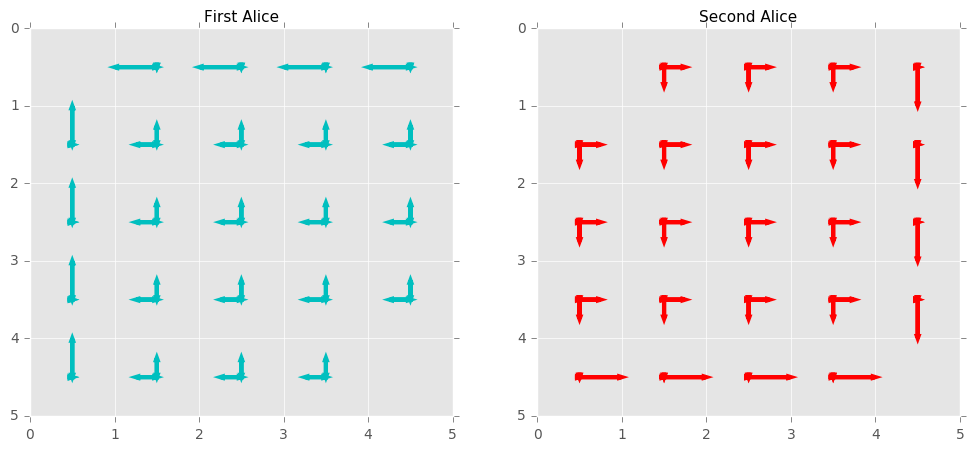

In [40]:
import matplotlib

def draw_direction_probs(ax, env, s, p, scale_arrow=0.5, arrow_width=3, arrow_color='c', eps=1e-5):
    i = (s) // env.shape[1]
    j = (s) % env.shape[1]
    
    ax.arrow(j + 0.5, i + 0.5, p[1] * scale_arrow + eps, 0, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, 0, p[2] * scale_arrow + eps, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, -p[3] * scale_arrow + eps, 0, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, 0, -p[0] * scale_arrow + eps, linewidth=arrow_width, color=arrow_color, length_includes_head=True)

    
matplotlib.style.use("ggplot")
fig, ax = subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].set_xticks(np.arange(0, 6))
ax[0].set_yticks(np.arange(0, 6))
heat_map = np.zeros((5, 5))
heat_map[0][0] += 1
heat_map[4][4] += 1
ax[1].set_xticks(np.arange(0, 6))
ax[1].set_yticks(np.arange(0, 6))
#ax[0].gca().invert_yaxis()
#ax[1].gca().invert_yaxis()

#ax.arrow(0 + 0.5, 0 + 0.5, 0, -1, linewidth=5, color='c', length_includes_head=True)

for s in range(0, env.nS):
    if(s == 0 or s == 24):
        continue
    else:
        
        draw_direction_probs(ax[0], env, s, Alice_left_corner.get_action_probs(env, s), arrow_color='c')
        draw_direction_probs(ax[1], env, s, Alice_right_corner.get_action_probs(env, s), arrow_color='r')

ax[0].invert_yaxis()
ax[1].invert_yaxis()

ax[0].set_title("First Alice", fontsize=11)
ax[1].set_title("Second Alice", fontsize=11)
plt.savefig("presa_example")

In [227]:
models_Alice = [Alice_right_corner, Alice_left_corner]

In [228]:
model_Bob = Policy(state_dim, action_dim)

#optimizer_Alice = optim.SGD(model_Alice.parameters(), lr=lr_Alice)
#optimizer_Bob = optim.SGD(model_Bob.parameters(), lr=lr_Bob)

#optimizer_Alice = optim.RMSprop(model_Alice.parameters(), alpha=0.97, eps=1e-6, lr=lr_Alice)
optimizer_Bob = optim.RMSprop(model_Bob.parameters(), alpha=0.97, eps=1e-6, lr=lr_Bob)

In [229]:
plots_dir = "plots_union/no_entropy_one_hot_random_init_100/"

0
24
None


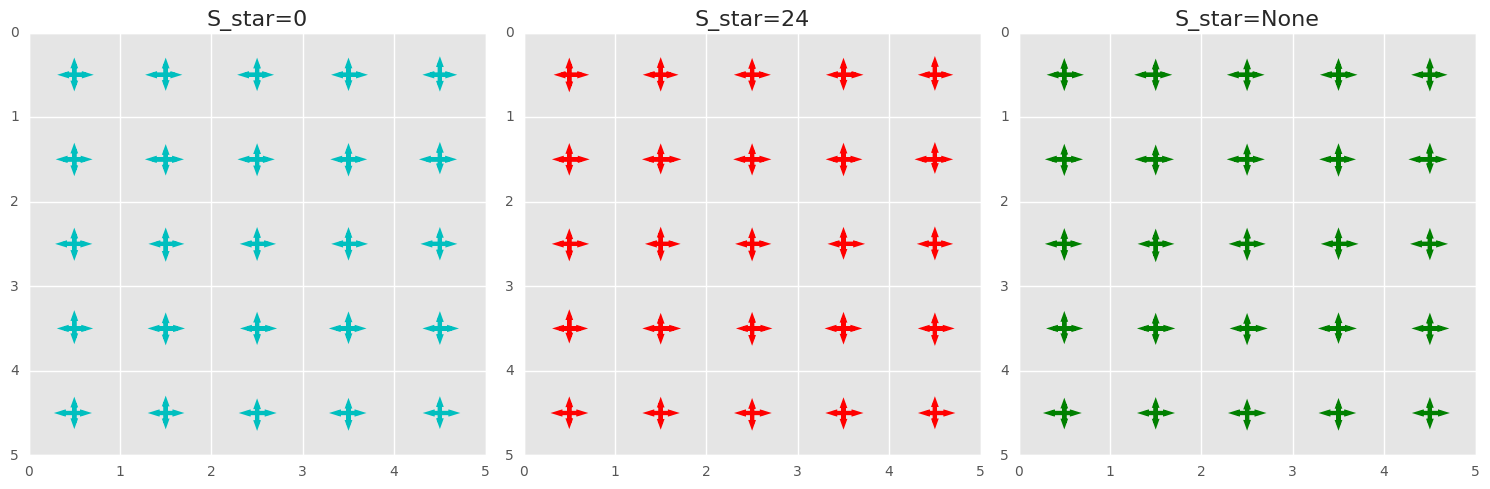

In [230]:
fig, ax = subplots(nrows=1, ncols=3, figsize=(15, 5))
s_stars = [0, env.nS - 1, None]
colors = ["c", "red", "green"]
for j, s_star in enumerate(s_stars):
    print(s_star)
    for s in range(0, env.nS):
        
        ax[j].set_xticks(np.arange(0, 6))
        ax[j].set_yticks(np.arange(0, 6))
        probs, state_value = model_Bob(s, s_star)
        draw_direction_probs(ax[j], env, s, probs[0].data, arrow_color=colors[j])
        ax[j].set_title("S_star={}".format(str(s_star)), fontsize=16)
        ax[j].invert_yaxis()

fig.tight_layout()

plt.savefig(os.path.join(plots_dir, "action_prob_plot{}".format(0)))

In [231]:
import matplotlib
from tqdm import tnrange
matplotlib.style.use("ggplot")
episodes_step = 100
stats_term = 1
times = 500
start = 0

for i in tnrange(times):
    model_Alice = models_Alice[i % 2]
    model_Bob, rewards, time, finish_states = pretrain_model(env, 40, model_Alice, model_Bob, episodes_step, 
                                                             stats_term=stats_term, pretraining_type="Repeat")
    
    #actio_prob_plot
    fig, ax = subplots(nrows=1, ncols=3, figsize=(15, 5))
    colors = ["c", "red", "green"]
    for j, s_star in enumerate(s_stars):
        for s in range(0, env.nS):

            ax[j].set_xticks(np.arange(0, 6))
            ax[j].set_yticks(np.arange(0, 6))
            probs, state_value = model_Bob(s, s_star)
            draw_direction_probs(ax[j], env, s, probs[0].data, arrow_color=colors[j])
            ax[j].set_title("S_star={}".format(str(s_star)), fontsize=16)
            ax[j].invert_yaxis()
    fig.tight_layout()
    plt.savefig(os.path.join(plots_dir, "action_prob_plot{}".format(episodes_step * (start + i + 1))))
    plt.clf()
    
    #reward_time_plot
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax[0].plot(rewards, label="Bob's reward")
    ax[1].plot(time, label="Bob's time")
    ax[2].hist(finish_states, color='c', alpha=0.5, label="Bob")

    ax[0].set_xlabel("episode")
    ax[1].set_xlabel("episode")
    ax[1].set_ylabel("steps")
    ax[0].set_ylabel("reward")
    ax[2].set_xlabel("final state")
    ax[2].set_ylabel("distribution")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[2].legend(loc="best")
    fig.tight_layout()
    plt.savefig(os.path.join(plots_dir, "reward_time_final{}".format(episodes_step * (start + i + 1))))
    plt.clf()
    #plt.savefig("plots_union_no_entropy_one_hot/reward_time_final{}".format(episodes_step * (start + i + 1)))
    
    #final_states_heat_map
    dense_Bob = np.zeros((5, 5))
    for finish in finish_states:
        dense_Bob[finish // 5][finish % 5] += 1

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    ax.imshow(dense_Bob, cmap='hot', interpolation='nearest')
    ax.set_title("Bob final states")

    plt.savefig(os.path.join(plots_dir, "final_states{}".format(episodes_step * (start + i + 1))))
    plt.clf()
    
    fig, ax = subplots(nrows=1, ncols=3, figsize=(12, 5))
    for j in range(3):
        ax[j].set_xticks(np.arange(0, 6))
        ax[j].set_yticks(np.arange(0, 6))
        ax[j].invert_yaxis()

    for j, s_star in enumerate([0, 24, None]):
        state_dist, state_dist_list = play_n_episodes(100, env, model_Bob, s_star)   
        for s in range(env.nS):
            value = model_Bob(s, s_star)[1].data[0][0]
            #states_heat_map[int(s // np.sqrt(env.nS))][s % int(np.sqrt(env.nS))] = value
            draw_value_anotate(ax[j], env, s, value)
        ax[j].imshow(state_dist, cmap='hot', interpolation='nearest')
        ax[j].set_title("S_star={}".format(str(s_star)), fontsize=16)
    
    plt.savefig(os.path.join(plots_dir, "value_state_distr{}".format(episodes_step * (start + i + 1))))
    plt.clf()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/andrejklimkin/anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/andrejklimkin/anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [232]:
probs, state_value = model_Bob(1, 0)
print(state_value)

Variable containing:
-3.7715
[torch.FloatTensor of size 1x1]



In [49]:
model_Bob(0, None)[1].data[0][0]

-0.9784899950027466

In [54]:
states_heat_map

array([[-0.97849, -0.97849, -0.97849, -0.97849, -0.97849],
       [-0.97849, -0.97849, -0.97849, -0.97849, -0.97849],
       [-0.97849, -0.97849, -0.97849, -0.97849, -0.97849],
       [-0.97849, -0.97849, -0.97849, -0.97849, -0.97849],
       [-0.97849, -0.97849, -0.97849, -0.97849, -0.97849]])

In [138]:
def draw_value_anotate(ax, env, s, value, font_color='c'):
    i = (s) // env.shape[1]
    j = (s) % env.shape[1]
    
    ax.annotate("%.2f" % value, xy=(j-0.3, i), color='c', fontsize=11)

In [131]:
state_dist

array([[ 0.35,  0.18,  0.13,  0.36,  0.13],
       [ 0.35,  0.23,  0.12,  0.25,  0.11],
       [ 0.6 ,  0.16,  0.07,  0.12,  0.14],
       [ 0.62,  0.05,  0.08,  0.62,  0.65],
       [ 0.28,  0.43,  0.65,  0.46,  0.65]])

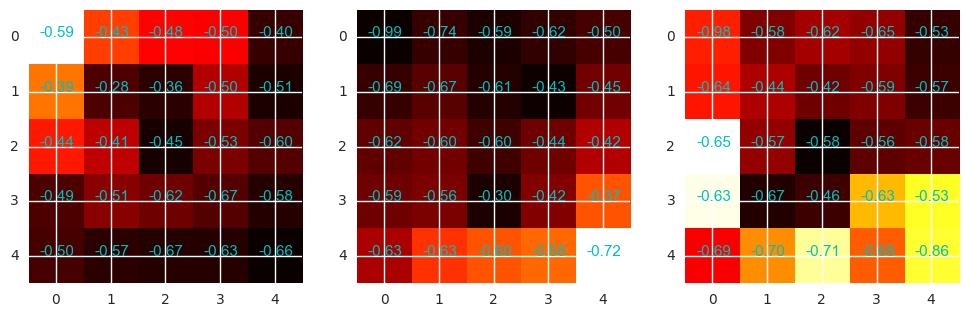

In [140]:
import seaborn as sns
fig, ax = subplots(nrows=1, ncols=3, figsize=(12, 5))
for i in range(3):
    ax[i].set_xticks(np.arange(0, 6))
    ax[i].set_yticks(np.arange(0, 6))
    ax[i].invert_yaxis()

for i, s_star in enumerate([0, 24, None]):
    state_dist, state_dist_list = play_n_episodes(100, env, model_Bob, s_star)   
    for s in range(env.nS):
        value = model_Bob(s, s_star)[1].data[0][0]
        #states_heat_map[int(s // np.sqrt(env.nS))][s % int(np.sqrt(env.nS))] = value
        draw_value_anotate(ax[i], env, s, value)
    ax[i].imshow(state_dist, cmap='hot', interpolation='nearest')
#ax[0].colorbar()

In [93]:
sns.despine(states_heat_map)

AttributeError: 'numpy.ndarray' object has no attribute 'axes'

In [60]:
states_heat_map

array([[-0.59381258, -0.43023404, -0.47775382, -0.50098127, -0.40126941],
       [-0.38833085, -0.27976575, -0.36261141, -0.49572831, -0.51082337],
       [-0.43805   , -0.41263515, -0.44584924, -0.52505875, -0.60363269],
       [-0.49151981, -0.50533783, -0.61683792, -0.67397845, -0.57913858],
       [-0.4980616 , -0.56829864, -0.66737449, -0.63027173, -0.6630401 ]])

In [27]:
# torch.save(model_Bob, 'model_Bob.pt')
# model = torch.load('model_Bob.pt')

/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
rewards = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -330, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -360]
torch.Tensor(rewards)

In [33]:
gamma

<function RandomState.gamma>

In [ ]:
w = torch.Tensor(3, 5)
nn.init.uniform(w)

In [ ]:
1